<a href="https://colab.research.google.com/github/sai8e/StockMarketProject/blob/main/Jonathan_Nope_Using_Python_%26_Machine_Learning_to_Predict_Stock_Prices_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Description: This Program uses an artifical recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Apple Inc.) using past 60 day stock price.

In [ ]:
!pip install yfinance
!pip install requests
!pip install lxml
!pip install numpy
!pip install pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade yfinance

In [ ]:
# Import the Libraries
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import io
import os
import csv
import glob
from google.colab import files

In [ ]:
#Declare Variables
file_ex = ".csv"
compare_data = 'Average'
date = dt.datetime.now()
end_date = date.strftime('%Y') + '-' + date.strftime('%m') + '-' + date.strftime('%d')
start_date = str(int(date.strftime('%Y')) - 10) + '-' + date.strftime('%m') + '-' + date.strftime('%d')

In [ ]:
#Declare Ticker
all_filenames = [i for i in glob.glob(f"*{file_ex}")]
for file in all_filenames:
    os.remove(file)
while True:
  ticker = input('Please input Ticker (Example "AAPL"):')
  try:
    add_avg = []
    add_dayChange = []
    df = pdr.get_data_yahoo(ticker, start, end)
    previousAVG = 0
    open_list = df['Open'].tolist()
    close_list = df['Close'].tolist()
    for i in range(len(open_list)):
        dayAVG = (open_list[i] + close_list[i]) / 2
        add_avg.append(dayAVG)
        dayAVGChange = (dayAVG - previousAVG)
        previousAVG = dayAVG
        add_dayChange.append(dayAVGChange)
    AVG = np.array(add_avg)
    dChange = np.array(add_dayChange)
    df['Average'] = AVG.tolist()
    df['AVGChange'] = dChange.tolist()
    df.to_csv(ticker + file_ex)
    df = pd.read_csv(ticker + file_ex)
    break
  except:
    print('Sorry Ticker is not in database! Please Try Again')

Please input Ticker (Example "AAPL"):TSLA


In [ ]:
print('TICKER: '+ ticker)
print(df)

TICKER: TSLA
            Date         High          Low  ...    Adj Close      Average  AVGChange
0     2016-11-01    39.700001    37.622002  ...    38.158001    38.883001  38.883001
1     2016-11-02    38.540001    37.501999  ...    37.604000    37.806999  -1.076002
2     2016-11-03    38.293999    37.408001  ...    37.484001    37.642000  -0.164999
3     2016-11-04    38.692001    37.192001  ...    38.112000    37.955999   0.313999
4     2016-11-07    38.858002    38.009998  ...    38.641998    38.679998   0.723999
...          ...          ...          ...  ...          ...          ...        ...
1254  2021-10-26  1094.939941  1001.440002  ...  1018.429993  1021.559967  33.864960
1255  2021-10-27  1070.880005  1030.780029  ...  1037.859985  1038.760010  17.200043
1256  2021-10-28  1081.000000  1054.199951  ...  1077.040039  1072.675049  33.915039
1257  2021-10-29  1115.209961  1073.209961  ...  1114.000000  1097.929993  25.254944
1258  2021-11-01  1209.750000  1118.660034  ...  120

In [ ]:
df.shape

(1259, 9)

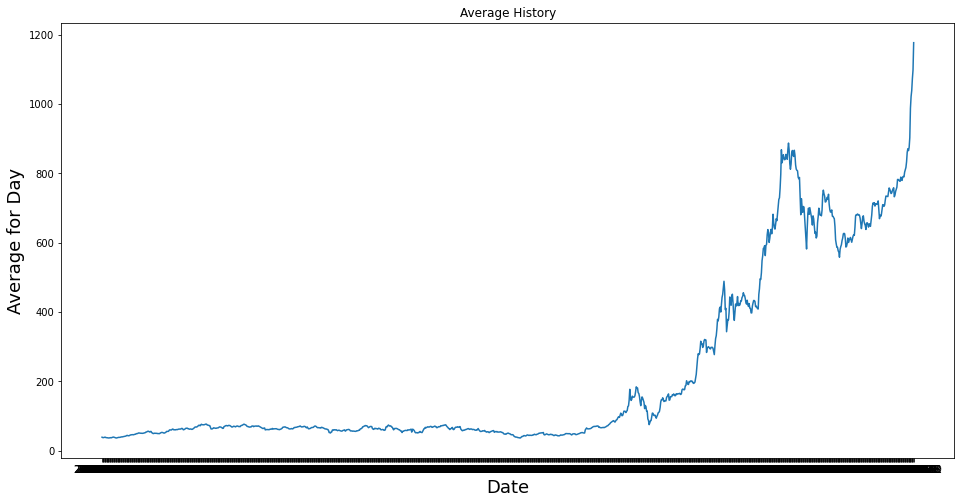

In [ ]:
#Visualize Close Price
plt.figure(figsize=(16,8))
plt.title(compare_data + ' History')
plt.plot(df['Date'], df[compare_data])
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.show()

In [ ]:
# create a new dataframe  with only the comapre_data column
data = df.filter([compare_data])
# convert the dataframe to a numpy array
dataset = data.values
# get the number of rows to train the LSTM model
training_data_len = math.ceil(len(dataset)*.80)


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
   x_train.append(train_data[i-60:i, 0])
   y_train.append(train_data[i, 0])

In [ ]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

In [ ]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1954/1954 [==============================] - 61s 30ms/step - loss: 2.1460e-04


In [ ]:
# Create testing dataset
# Create new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]
# Create data set x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
  

In [ ]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

In [ ]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [ ]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions- y_test)**2)
rmse

In [ ]:
# Plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel(compare_data +' for Day', fontsize=18)
plt.plot(train[compare_data])
plt.plot(valid[[compare_data, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted price
valid